In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels plotly

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 4.2 MB/s eta 0:00:36
   ---------------------------------------- 0.8/150.0 MB 5.6 MB/s eta 0:00:27
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.3/150.0 MB 1.2 MB/s eta 0:02:09
   ---------------------------------------- 1.3/150.0 MB 1.2 MB/s eta 0:02:09
   ---------------------------------------- 1.6/150.0 MB 1.0 MB/s eta 0:02:26
   ---------------------------------------- 1.6/150.0 MB 1.0 MB/s eta 0:02:26
   ---------------------------------------- 1.8/150.0 MB 923.6 kB/s eta 0:02:41
   ---------------------------------------- 1.8/150.0 MB 923.6 kB/s eta 0:02:41
    --------------------------------------- 2.1/150.0 MB 876.7 kB/s eta 0:02:49
    --------------------------------------- 2.1/150.0 MB 876.7 kB

时间范围: 2020-01-01 00:10:00 到 2021-01-01 00:00:00
总记录数: 52696
时间分辨率: 10 分钟

缺失值比例:
Series([], dtype: float64)

填充后缺失值总数: 0

关键变量描述性统计:
                     count    mean     std      min     25%     50%     75%  \
temperature        52696.0   10.82    7.47    -6.44    4.59   10.23   16.18   
relative_humidity  52696.0   72.49   19.23    21.16   58.82   75.40   87.90   
wind_speed         52696.0    2.00   43.60 -9999.00    1.00    1.77    2.92   
rainfall           52696.0    0.01    0.12     0.00    0.00    0.00    0.00   
solar_radiation    52696.0  131.33  215.74     0.00    0.00    2.82  182.90   
target             52696.0  417.80  321.57 -9999.00  415.50  423.20  437.10   

                       max  
temperature          34.80  
relative_humidity   100.00  
wind_speed           13.77  
rainfall             11.20  
solar_radiation    1115.29  
target              524.20  


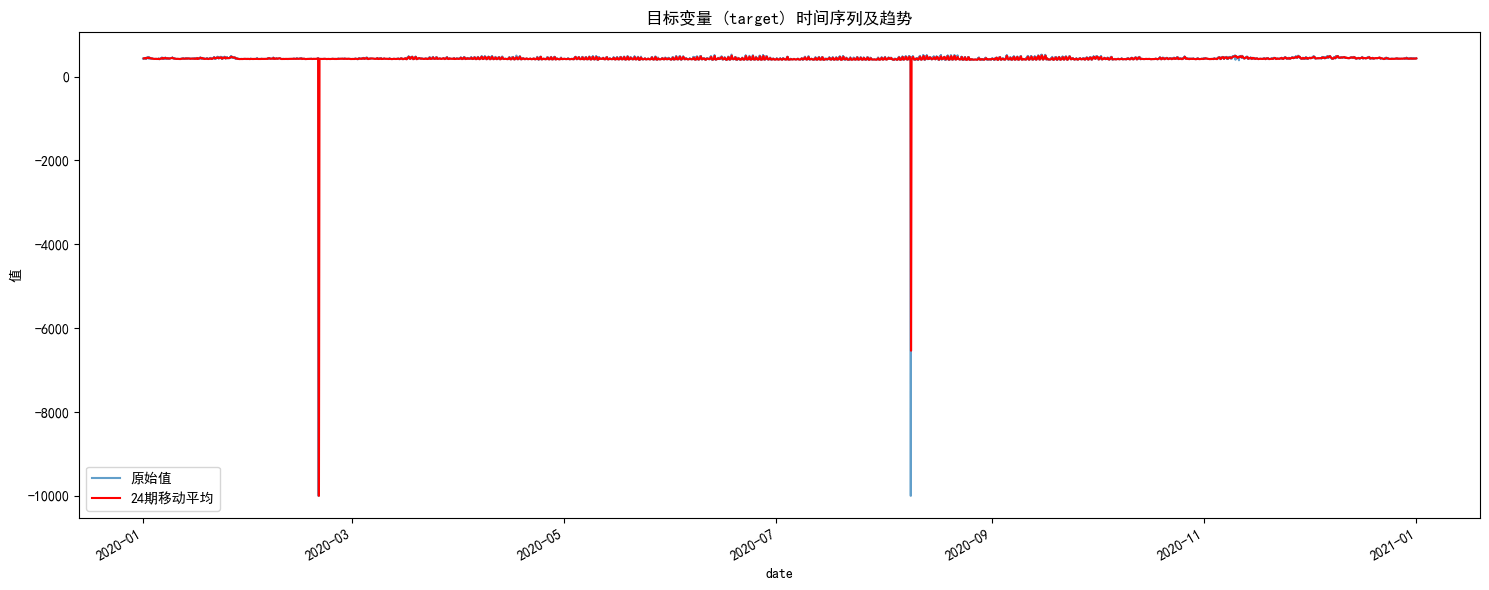

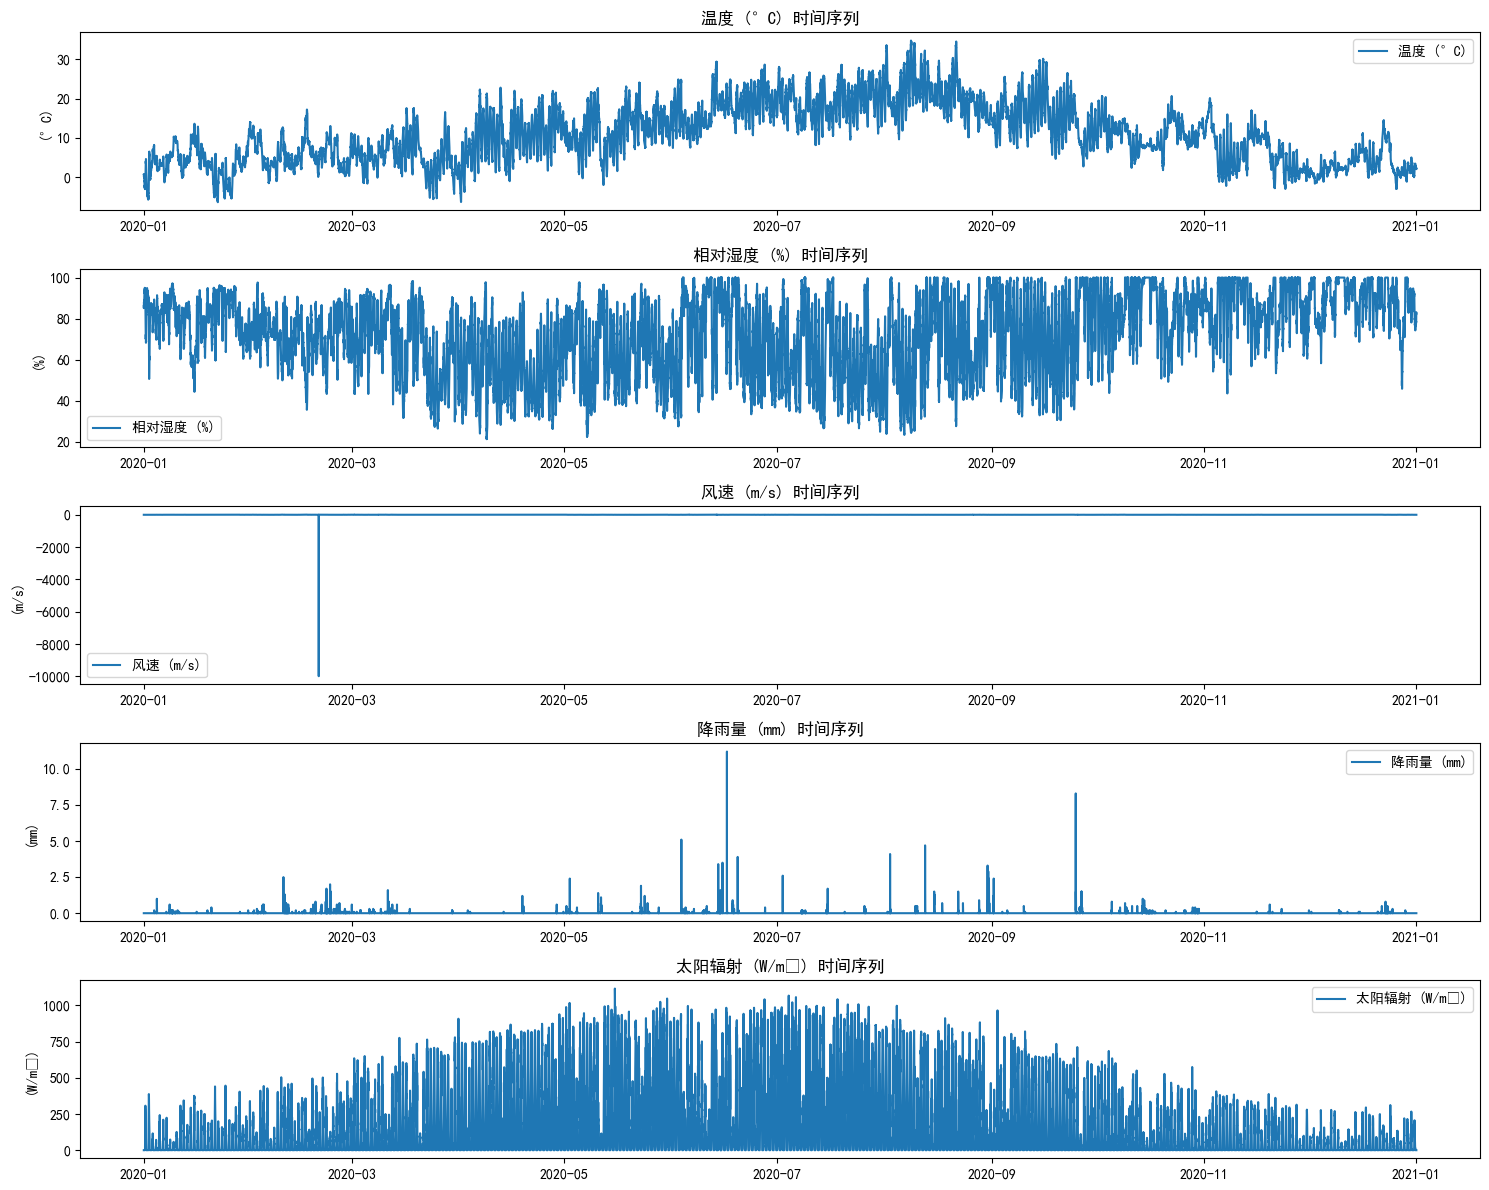

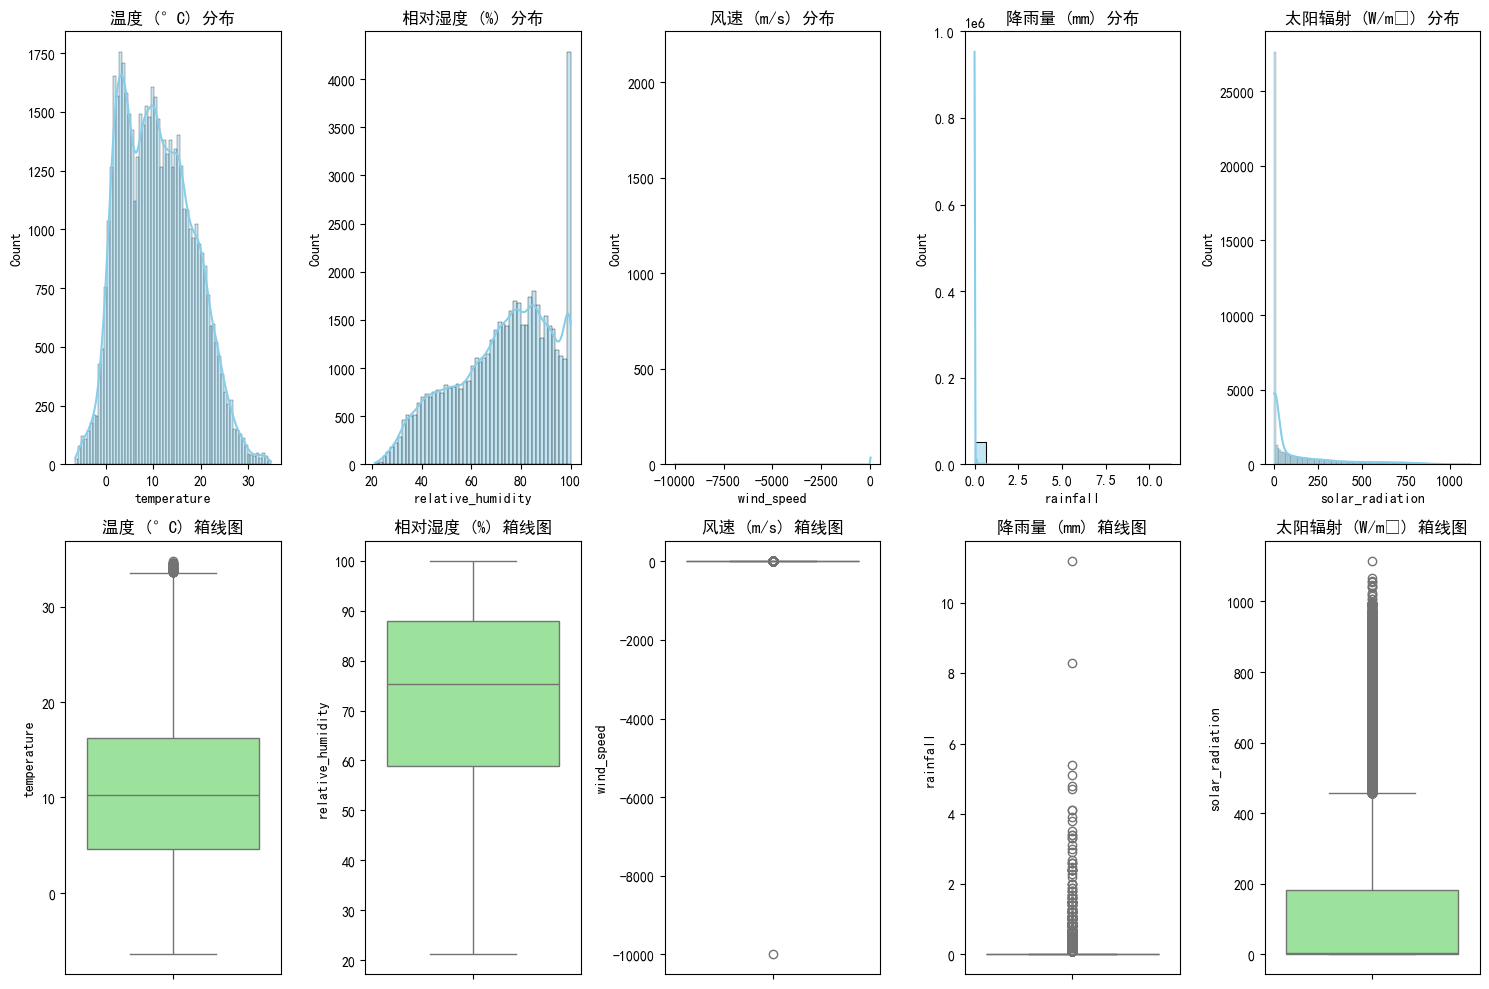

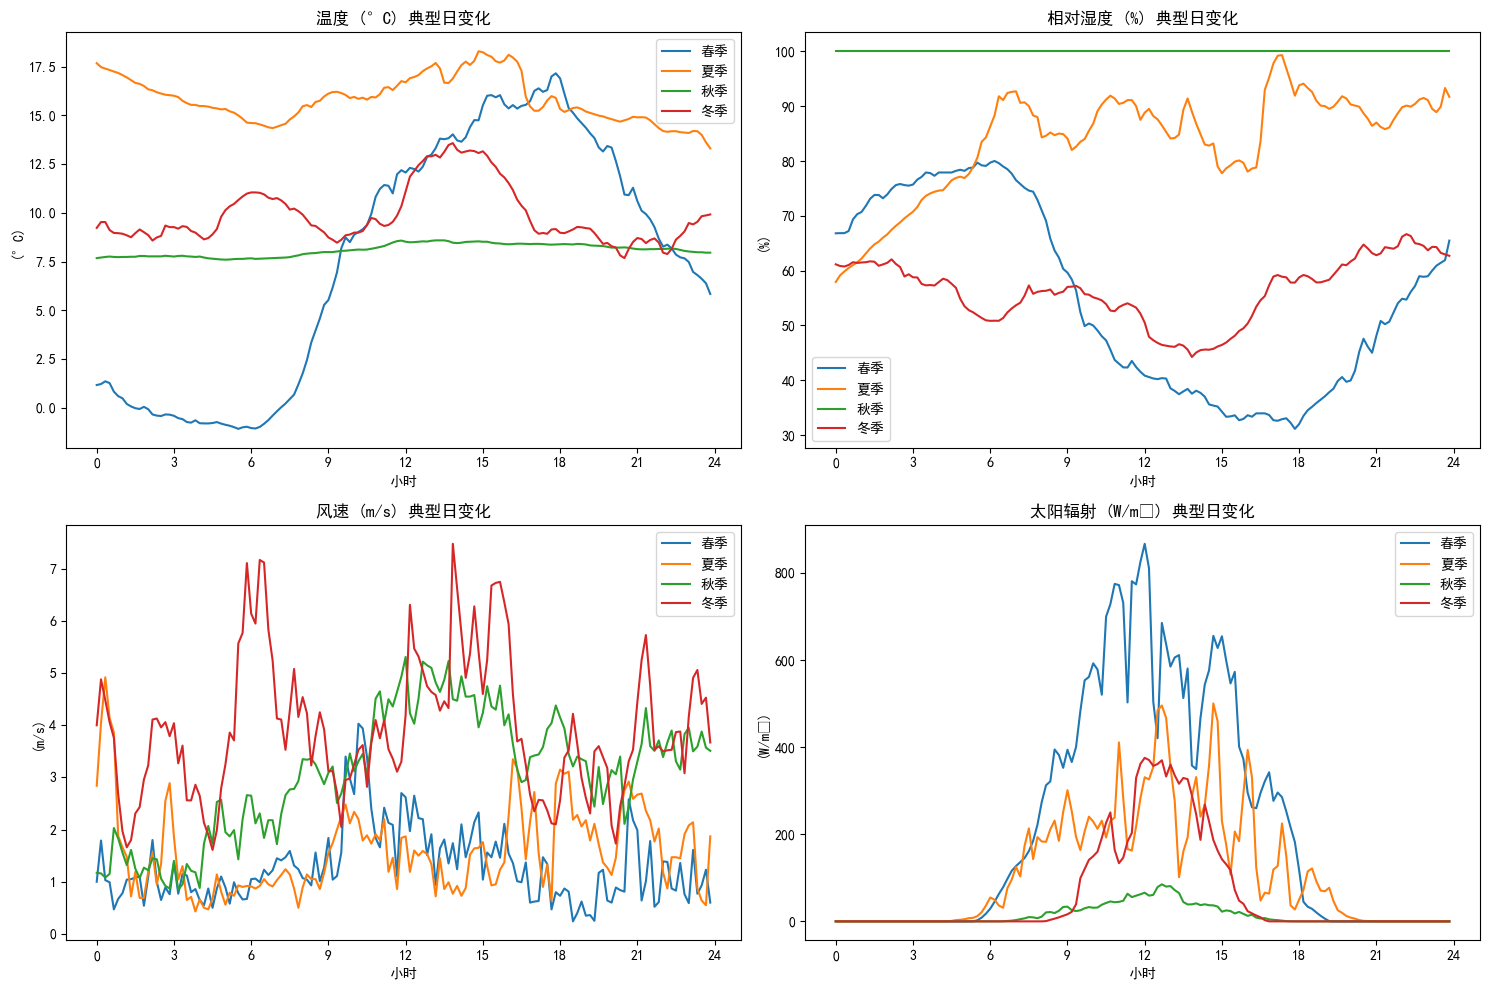

温度 季节性分解错误: x must have 2 complete cycles requires 730 observations. x only has 367 observation(s)
相对湿度 季节性分解错误: x must have 2 complete cycles requires 730 observations. x only has 367 observation(s)


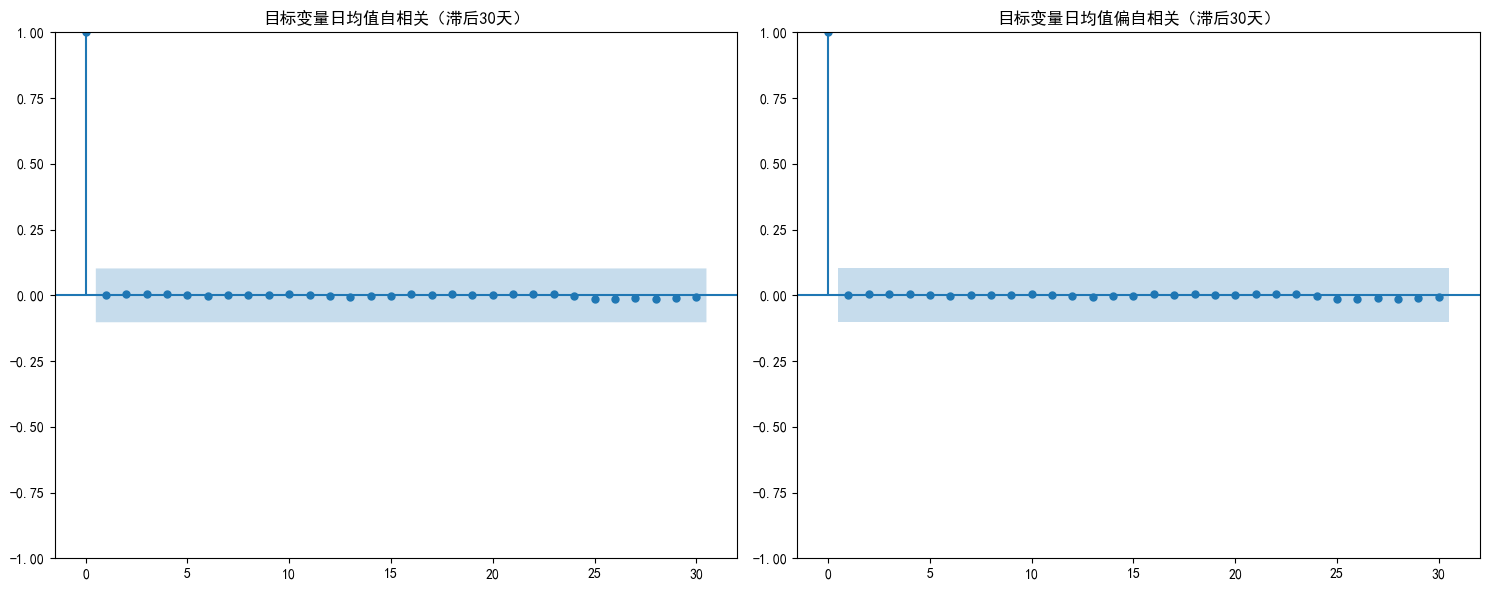


目标变量与关键气象因子相关性:
target               1.000
wind_speed           0.140
relative_humidity    0.051
rainfall             0.000
solar_radiation     -0.036
temperature         -0.039
Name: target, dtype: float64


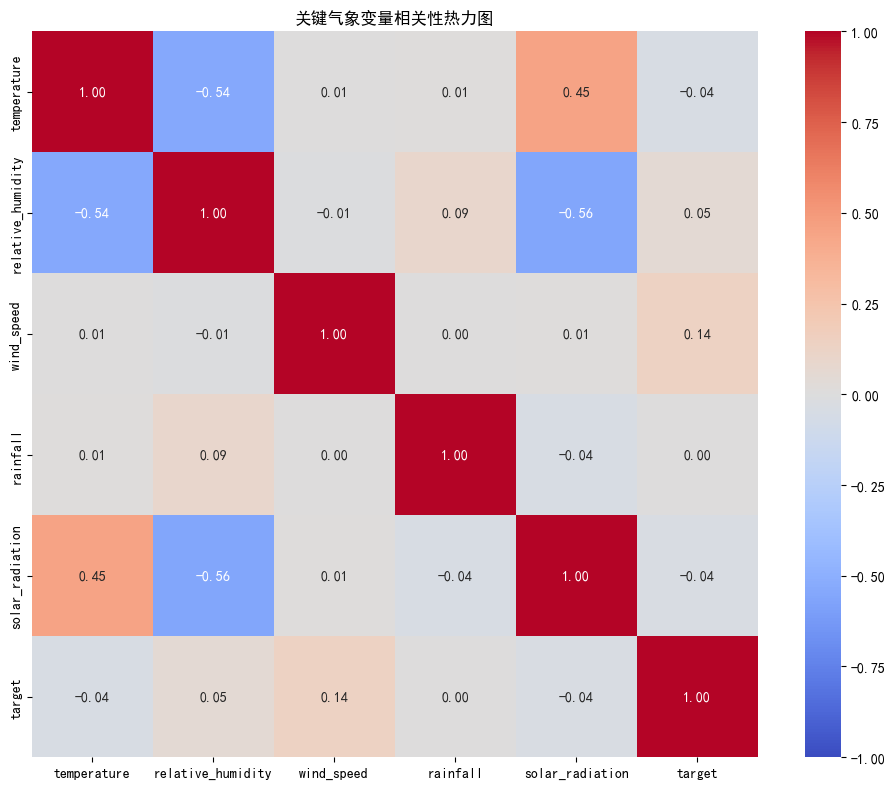

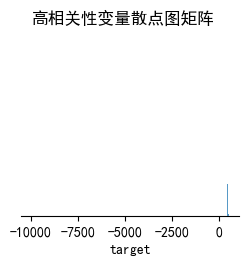

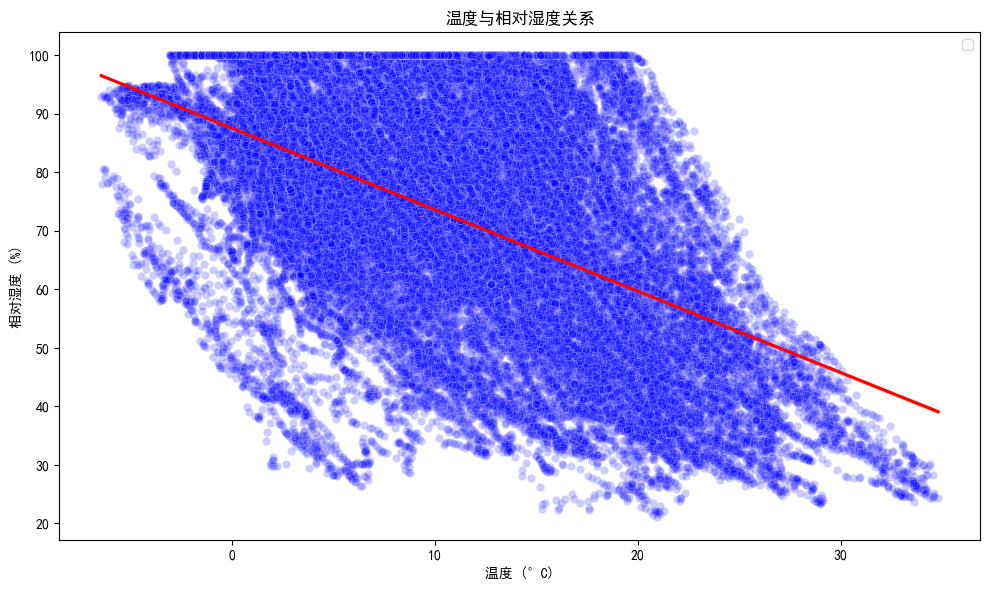


异常点数量（两种方法共识）: 27 (0.05%)


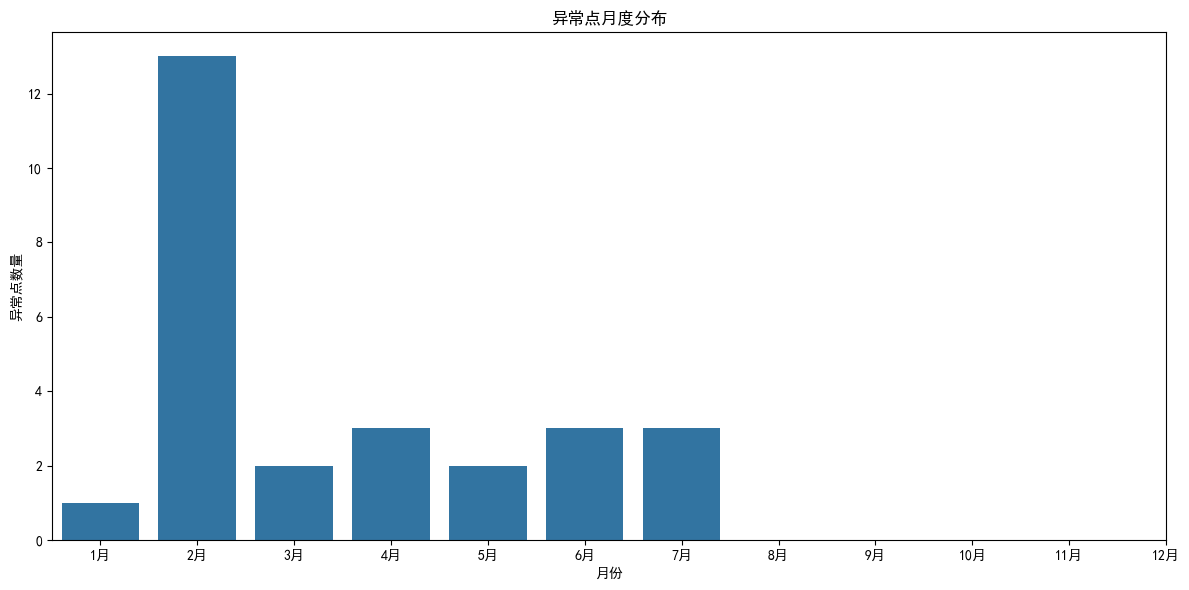

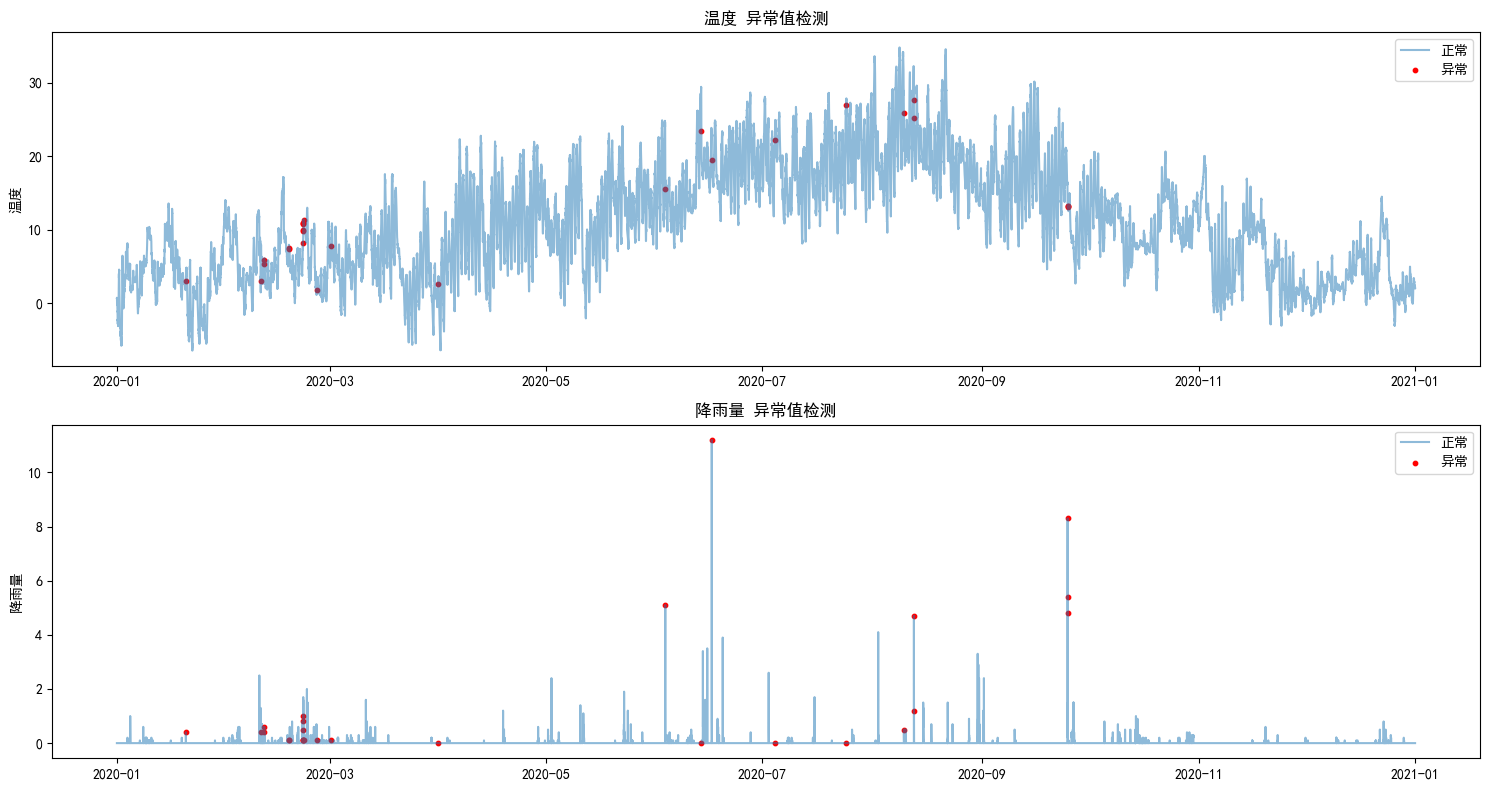


异常点关键气象变量统计:
       temperature  relative_humidity  wind_speed  rainfall  solar_radiation
count        27.00              27.00       27.00     27.00            27.00
mean         12.68              60.56        5.94      1.71           259.63
std           7.97              19.80        3.00      2.91           298.60
min           1.80              29.79        0.81      0.00             0.00
25%           7.44              45.17        4.05      0.10            17.10
50%          10.94              56.07        5.52      0.40           189.54
75%          17.52              70.11        8.31      1.10           337.92
max          27.65             100.00       10.39     11.20          1066.75


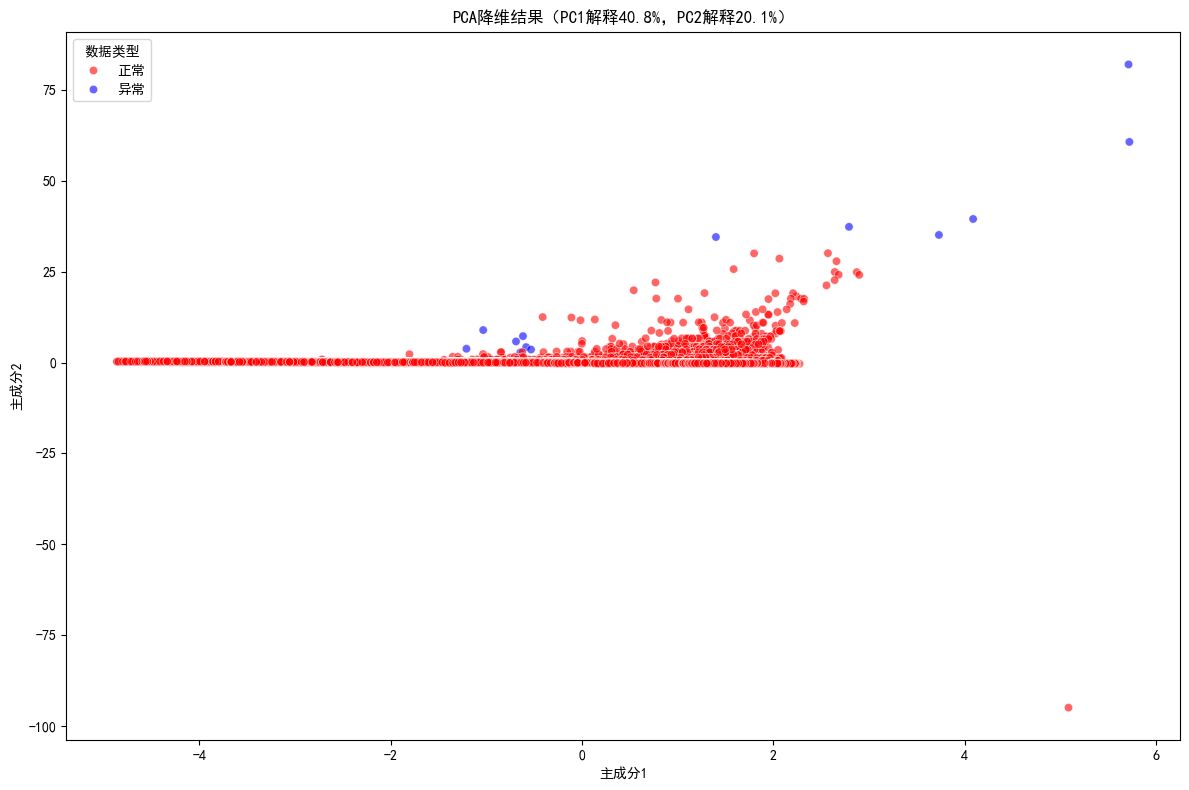


PCA特征载荷（变量对主成分的贡献）:
                     PC1    PC2
temperature       -0.558  0.118
relative_humidity  0.601  0.033
wind_speed        -0.017  0.413
rainfall           0.070  0.902
solar_radiation   -0.567  0.017


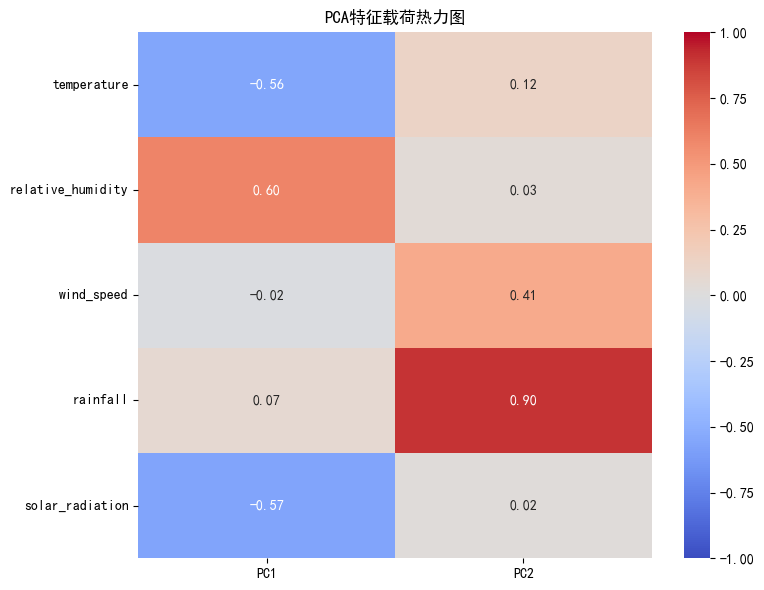

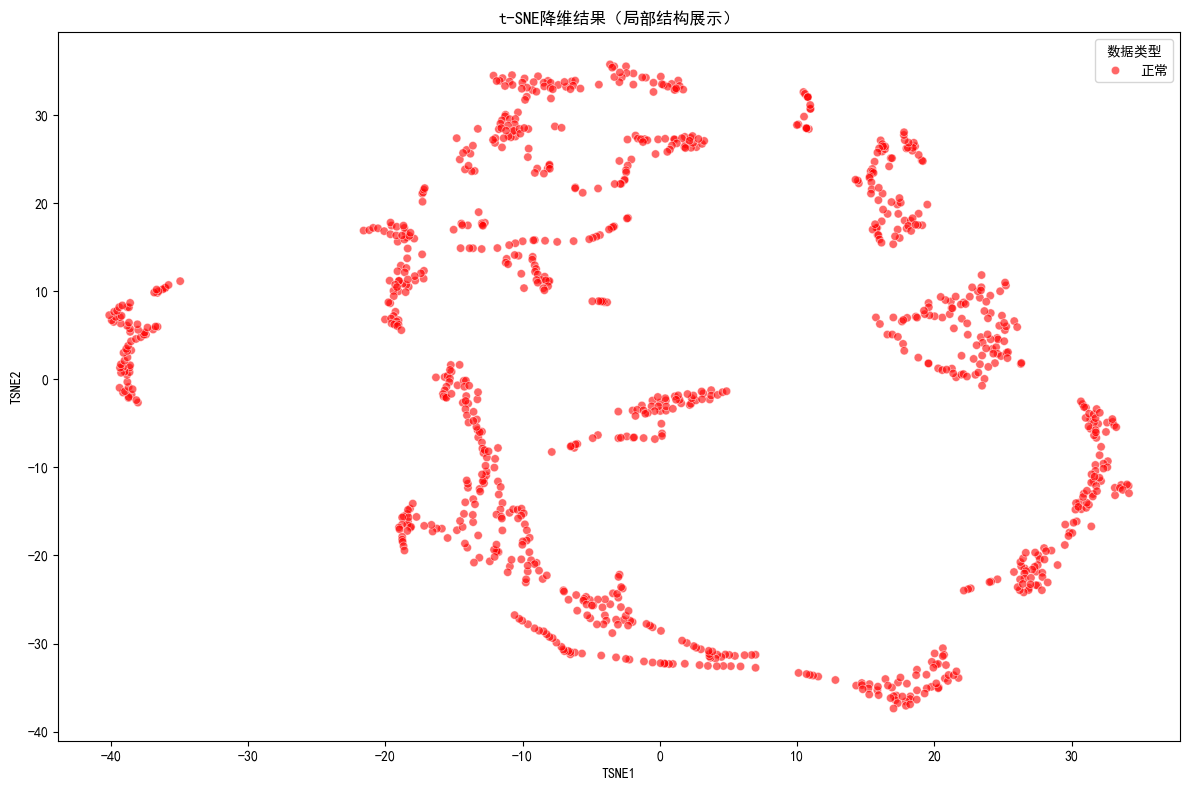

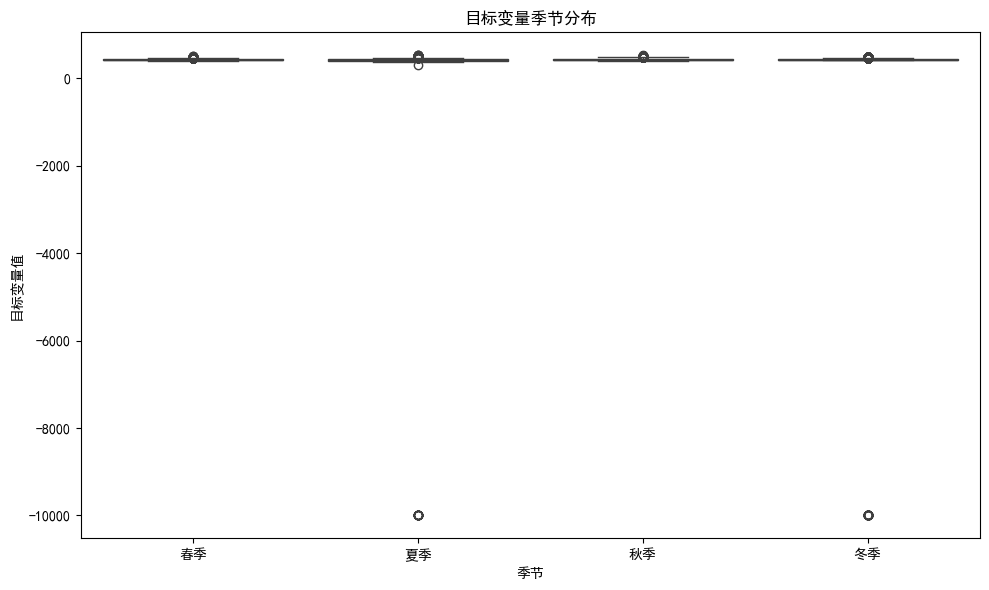

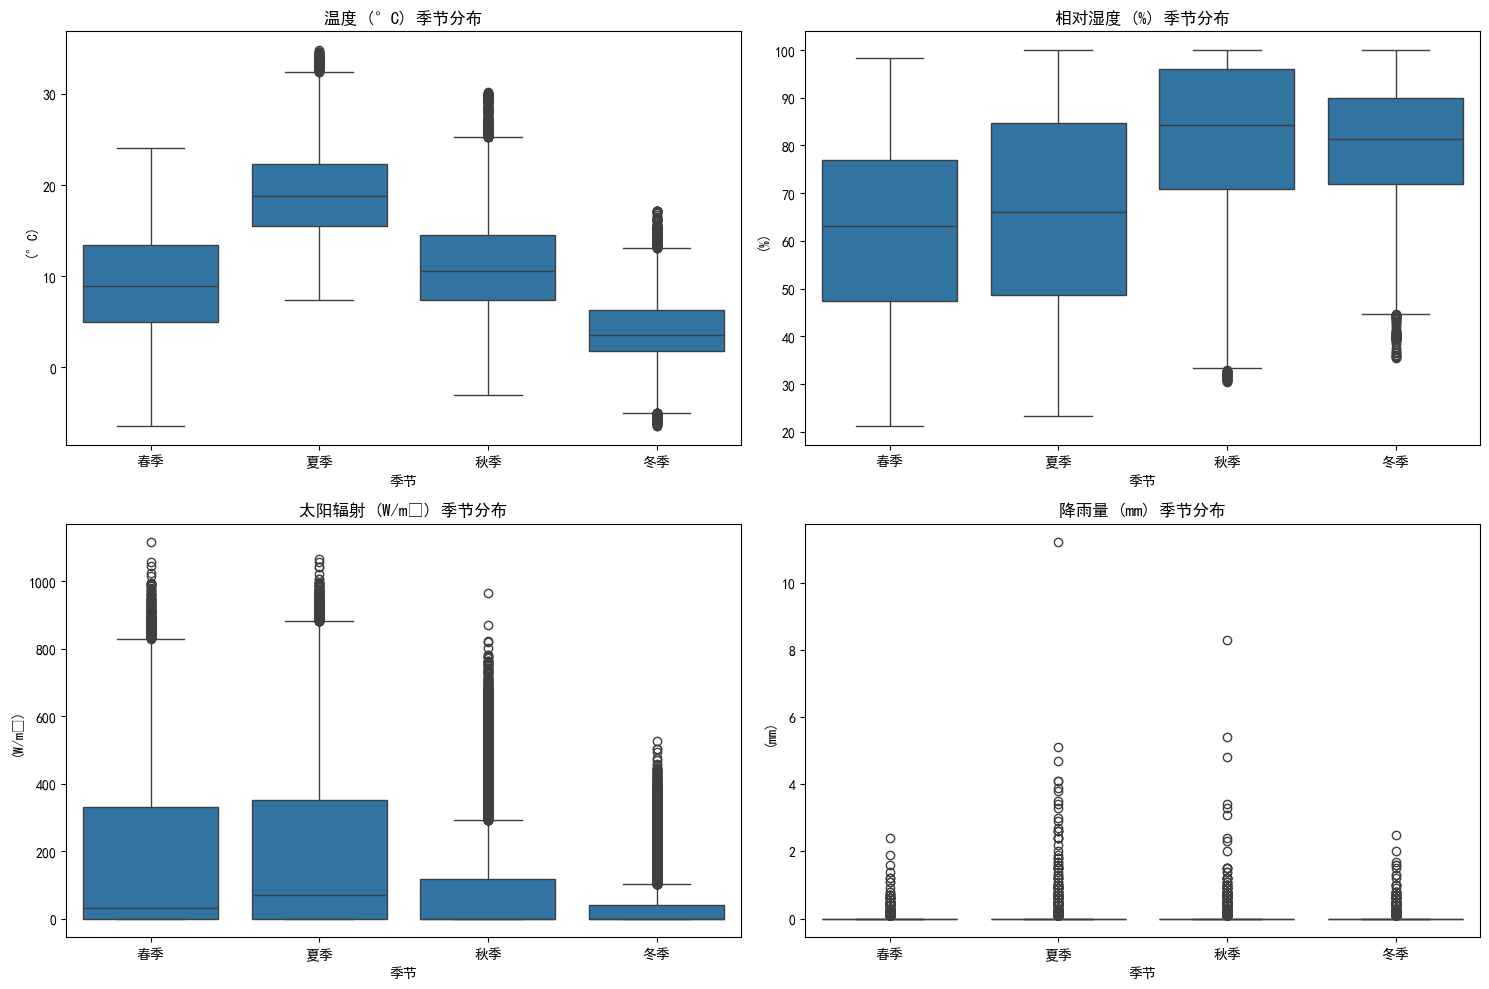

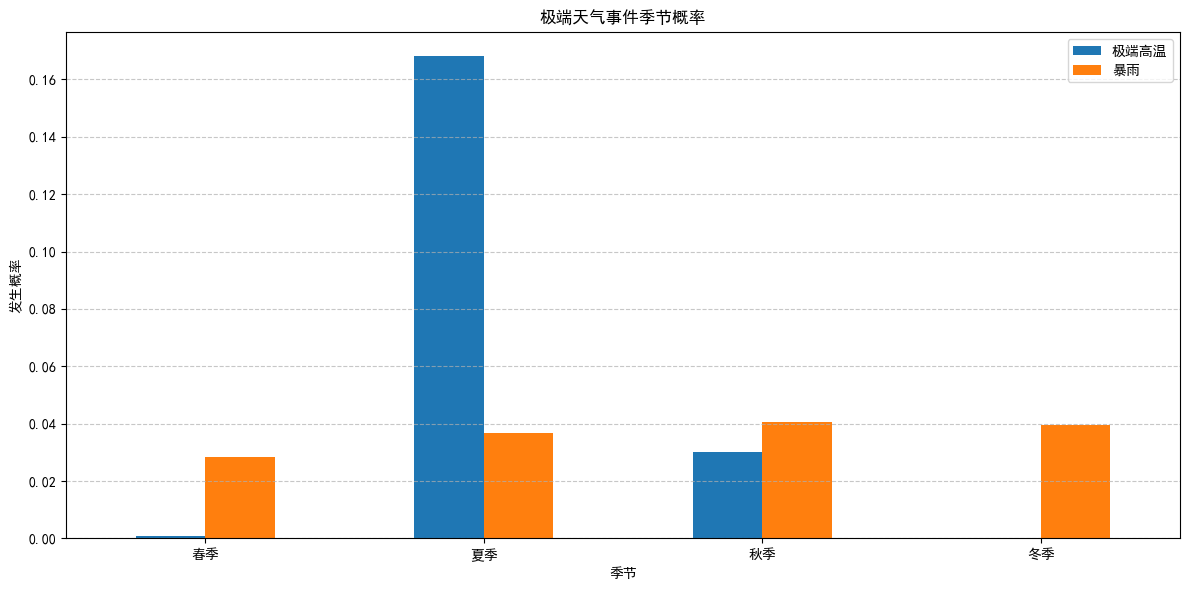


探索性分析完成！所有图表已保存为PNG文件。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与预处理
def load_weather_data(file_path):
    # 加载数据并解析日期
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
    
    # 重命名列（规范命名并转为中文描述）
    column_mapping = {
        'p (mbar)': 'pressure',                # 气压
        'T (degC)': 'temperature',             # 温度
        'Tpot (K)': 'potential_temp',          # 潜在温度
        'Tdew (degC)': 'dew_point',            # 露点温度
        'rh (%)': 'relative_humidity',         # 相对湿度
        'VPmax (mbar)': 'vapor_pressure_max',  # 最大水汽压
        'VPact (mbar)': 'vapor_pressure_actual',# 实际水汽压
        'VPdef (mbar)': 'vapor_pressure_deficit',# 水汽压亏缺
        'sh (g/kg)': 'specific_humidity',      # 比湿度
        'H2OC (mmol/mol)': 'water_vapor_concentration',# 水汽浓度
        'rho (g/m**3)': 'air_density',         # 空气密度
        'wv (m/s)': 'wind_speed',              # 风速
        'max. wv (m/s)': 'max_wind_speed',     # 最大风速
        'wd (deg)': 'wind_direction',          # 风向
        'rain (mm)': 'rainfall',               # 降雨量
        'raining (s)': 'raining_duration',     # 降雨持续时间
        'SWDR (W/m2)': 'solar_radiation',      # 太阳辐射
        'PAR (mol/m2/s)': 'photosynthetic_radiation',# 光合有效辐射
        'max. PAR (mol/m2/s)': 'max_photosynthetic_radiation',# 最大光合有效辐射
        'Tlog (degC)': 'log_temperature',      # 对数温度
        'OT': 'target'                         # 目标变量
    }
    df = df.rename(columns=column_mapping)
    
    # 数据基本信息
    print(f"时间范围: {df.index.min()} 到 {df.index.max()}")
    print(f"总记录数: {len(df)}")
    print(f"时间分辨率: {(df.index[1] - df.index[0]).seconds//60} 分钟")
    
    # 缺失值检查与处理
    missing_percentage = df.isnull().mean() * 100
    print("\n缺失值比例:")
    print(missing_percentage[missing_percentage > 0].round(2))
    
    # 时间序列插值填充缺失值
    df = df.interpolate(method='time')
    print(f"\n填充后缺失值总数: {df.isnull().sum().sum()}")
    
    return df


# 2. 增强版探索性分析
def exploratory_analysis(df):
    # 基础统计（保留关键变量）
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 
               'rainfall', 'solar_radiation', 'target']
    print("\n关键变量描述性统计:")
    print(df[key_vars].describe().T.round(2))
    
    # 目标变量时间序列（增加趋势线）
    plt.figure(figsize=(15, 6))
    df['target'].plot(label='原始值', alpha=0.7)
    df['target'].rolling(window=24).mean().plot(label='24期移动平均', color='red')  # 平滑趋势
    plt.title('目标变量 (target) 时间序列及趋势')
    plt.ylabel('值')
    plt.legend()
    plt.tight_layout()
    plt.savefig('target_time_series_with_trend.png')
    plt.show()
    
    # 关键气象变量时间序列（分区域展示）
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'solar_radiation']
    var_names = ['温度 (°C)', '相对湿度 (%)', '风速 (m/s)', '降雨量 (mm)', '太阳辐射 (W/m²)']
    
    plt.figure(figsize=(15, 12))
    for i, (var, name) in enumerate(zip(key_vars, var_names)):
        plt.subplot(5, 1, i+1)
        plt.plot(df.index, df[var], label=name)
        plt.title(f'{name} 时间序列')
        plt.ylabel(name.split()[1])  # 提取单位作为y轴标签
        plt.legend()
    plt.tight_layout()
    plt.savefig('key_variables_time_series.png')
    plt.show()
    
    # 关键变量分布对比（直方图+箱线图组合）
    plt.figure(figsize=(15, 10))
    for i, (var, name) in enumerate(zip(key_vars, var_names)):
        # 直方图
        plt.subplot(2, 5, i+1)
        sns.histplot(df[var], kde=True, color='skyblue')
        plt.title(f'{name} 分布')
        
        # 箱线图
        plt.subplot(2, 5, i+6)
        sns.boxplot(y=df[var], color='lightgreen')
        plt.title(f'{name} 箱线图')
    
    plt.tight_layout()
    plt.savefig('variables_distribution_comparison.png')
    plt.show()


# 3. 增强版时间序列特性分析
def time_series_analysis(df):
    # 定义函数内使用的变量
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 'solar_radiation', 'rainfall']
    var_names = ['温度 (°C)', '相对湿度 (%)', '风速 (m/s)', '太阳辐射 (W/m²)', '降雨量 (mm)']
    
    # 典型日分析（选择春、夏、秋、冬各一天）
    seasons = {
        '春季': '04-15',  # 4月15日
        '夏季': '07-15',  # 7月15日
        '秋季': '10-15',  # 10月15日
        '冬季': '01-15'   # 1月15日
    }
    
    # 筛选可用日期
    sample_days = {}
    for season, date_str in seasons.items():
        for year in df.index.year.unique():
            target_date = f'{year}-{date_str}'
            if pd.Timestamp(target_date) in df.index:
                sample_days[season] = df.loc[target_date]
                break
    
    # 绘制典型日变化曲线
    plt.figure(figsize=(15, 10))
    for i, (var, name) in enumerate(zip(key_vars[:4], var_names[:4])):  # 前4个变量
        plt.subplot(2, 2, i+1)
        for season, day_data in sample_days.items():
            time_axis = day_data.index.hour + day_data.index.minute/60  # 转换为小时
            plt.plot(time_axis, day_data[var], label=season)
        plt.title(f'{name} 典型日变化')
        plt.xlabel('小时')
        plt.ylabel(name.split()[1])
        plt.xticks(range(0, 25, 3))
        plt.legend()
    plt.tight_layout()
    plt.savefig('typical_day_patterns.png')
    plt.show()
    
    # 多变量季节性分解（温度+湿度）
    for var, name in zip(['temperature', 'relative_humidity'], ['温度', '相对湿度']):
        try:
            # 按日聚合后分解（年度季节性）
            daily_data = df[var].resample('D').mean()  # 日平均值
            decomposition = seasonal_decompose(daily_data.dropna(), period=365)
            
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
            decomposition.observed.plot(ax=ax1, title=f'{name} 观测值')
            ax1.set_ylabel(name)
            
            decomposition.trend.plot(ax=ax2, title=f'{name} 趋势')
            ax2.set_ylabel(name)
            
            decomposition.seasonal.plot(ax3, title=f'{name} 年度季节性')
            ax3.set_ylabel(name)
            
            plt.tight_layout()
            plt.savefig(f'{var}_seasonal_decomposition.png')
            plt.show()
        except Exception as e:
            print(f"{name} 季节性分解错误: {e}")
    
    # 自相关与偏自相关分析（目标变量）
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plot_acf(df['target'].resample('D').mean().dropna(), lags=30, ax=plt.gca())
    plt.title('目标变量日均值自相关（滞后30天）')
    
    plt.subplot(1, 2, 2)
    plot_pacf(df['target'].resample('D').mean().dropna(), lags=30, ax=plt.gca())
    plt.title('目标变量日均值偏自相关（滞后30天）')
    
    plt.tight_layout()
    plt.savefig('target_acf_pacf.png')
    plt.show()


# 4. 深化相关性分析
def correlation_analysis(df):
    # 关键变量相关性矩阵
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 
               'rainfall', 'solar_radiation', 'target']
    corr_matrix = df[key_vars].corr()
    
    # 目标变量相关性排序
    target_corr = corr_matrix['target'].sort_values(ascending=False)
    print("\n目标变量与关键气象因子相关性:")
    print(target_corr.round(3))
    
    # 相关性热力图（带注释）
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, 
                annot=True, fmt=".2f", square=True)
    plt.title('关键气象变量相关性热力图')
    plt.tight_layout()
    plt.savefig('key_variables_correlation.png')
    plt.show()
    
    # 高相关变量散点图矩阵（带回归线）
    high_corr_vars = target_corr[abs(target_corr) > 0.3].index.tolist()  # 筛选高相关变量
    sns.pairplot(df[high_corr_vars], kind='reg', corner=True, 
                 plot_kws={'line_kws': {'color': 'red'}, 'alpha': 0.3})
    plt.suptitle('高相关性变量散点图矩阵', y=1.02)
    plt.savefig('high_correlation_scatter_matrix.png')
    plt.show()
    
    # 湿度-温度关系（经典负相关）
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='temperature', y='relative_humidity', data=df, 
                   alpha=0.2, color='blue')
    sns.regplot(x='temperature', y='relative_humidity', data=df, 
               scatter=False, color='red', line_kws={'label': '回归线'})
    plt.title('温度与相对湿度关系')
    plt.xlabel('温度 (°C)')
    plt.ylabel('相对湿度 (%)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('temp_humidity_relationship.png')
    plt.show()
    
    return corr_matrix


# 5. 多方法异常检测与分析
def detect_anomalies(df):
    # 选择关键变量进行异常检测
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 
               'rainfall', 'solar_radiation']
    
    # 标准化数据
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[key_vars])
    
    # 方法1：隔离森林
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['iso_anomaly'] = iso_forest.fit_predict(scaled_data)
    
    # 方法2：局部离群因子
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
    df['lof_anomaly'] = lof.fit_predict(scaled_data)
    
    # 合并异常检测结果（两种方法都标记为异常才视为真异常）
    df['anomaly'] = np.where((df['iso_anomaly'] == -1) & (df['lof_anomaly'] == -1), -1, 1)
    anomalies = df[df['anomaly'] == -1]
    print(f"\n异常点数量（两种方法共识）: {len(anomalies)} ({len(anomalies)/len(df):.2%})")
    
    # 异常点时间分布
    plt.figure(figsize=(12, 6))
    anomalies['month'] = anomalies.index.month
    month_counts = anomalies['month'].value_counts().sort_index()
    sns.barplot(x=month_counts.index, y=month_counts.values)
    plt.title('异常点月度分布')
    plt.xlabel('月份')
    plt.ylabel('异常点数量')
    plt.xticks(range(12), [f'{i+1}月' for i in range(12)])
    plt.tight_layout()
    plt.savefig('anomaly_monthly_distribution.png')
    plt.show()
    
    # 关键变量异常值可视化（温度+降雨量）
    plt.figure(figsize=(15, 8))
    for i, (var, name) in enumerate(zip(['temperature', 'rainfall'], ['温度', '降雨量'])):
        plt.subplot(2, 1, i+1)
        plt.plot(df.index, df[var], label='正常', alpha=0.5)
        plt.scatter(anomalies.index, anomalies[var], color='red', label='异常', s=10)
        plt.title(f'{name} 异常值检测')
        plt.ylabel(name)
        plt.legend()
    plt.tight_layout()
    plt.savefig('temp_rain_anomalies.png')
    plt.show()
    
    # 异常点对应的气象条件
    print("\n异常点关键气象变量统计:")
    print(anomalies[key_vars].describe().round(2))
    
    return df, anomalies


# 6. 增强版多变量分析
def multivariate_analysis(df, anomalies):
    key_vars = ['temperature', 'relative_humidity', 'wind_speed', 
               'rainfall', 'solar_radiation']
    
    # 标准化数据
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[key_vars])
    
    # PCA分析（带异常标记）
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_data)
    
    pca_df = pd.DataFrame({
        'PC1': principal_components[:, 0],
        'PC2': principal_components[:, 1],
        'type': ['异常' if i in anomalies.index else '正常' for i in df.index]
    })
    
    # PCA可视化（区分正常/异常）
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='type', data=pca_df, 
                   alpha=0.6, palette=['red', 'blue'])
    plt.title(f'PCA降维结果（PC1解释{pca.explained_variance_ratio_[0]:.1%}，PC2解释{pca.explained_variance_ratio_[1]:.1%}）')
    plt.xlabel('主成分1')
    plt.ylabel('主成分2')
    plt.legend(title='数据类型')
    plt.tight_layout()
    plt.savefig('pca_with_anomalies.png')
    plt.show()
    
    # 特征载荷分析
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=key_vars
    )
    print("\nPCA特征载荷（变量对主成分的贡献）:")
    print(loadings.round(3))
    
    # 载荷热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(loadings, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
    plt.title('PCA特征载荷热力图')
    plt.tight_layout()
    plt.savefig('pca_loadings_heatmap.png')
    plt.show()
    
    # t-SNE降维（更好展示局部结构）
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data[:1000])  # 取前1000样本加速计算
    
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_results[:, 0],
        'TSNE2': tsne_results[:, 1],
        'type': ['异常' if i in anomalies.index else '正常' for i in df.index[:1000]]
    })
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='type', data=tsne_df, 
                   alpha=0.6, palette=['red', 'blue'])
    plt.title('t-SNE降维结果（局部结构展示）')
    plt.legend(title='数据类型')
    plt.tight_layout()
    plt.savefig('tsne_analysis.png')
    plt.show()


# 7. 深化季节模式分析
def seasonal_analysis(df):
    # 添加季节标签
    seasons = {1: '冬季', 2: '冬季', 3: '春季', 4: '春季', 5: '春季',
               6: '夏季', 7: '夏季', 8: '夏季', 9: '秋季', 10: '秋季',
               11: '秋季', 12: '冬季'}
    df['season'] = df.index.month.map(seasons)
    df['hour'] = df.index.hour  # 小时特征
    
    # 目标变量季节分布
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='season', y='target', data=df, order=['春季', '夏季', '秋季', '冬季'])
    plt.title('目标变量季节分布')
    plt.xlabel('季节')
    plt.ylabel('目标变量值')
    plt.tight_layout()
    plt.savefig('target_seasonal_distribution.png')
    plt.show()
    
    # 关键变量季节箱线图对比
    key_vars = ['temperature', 'relative_humidity', 'solar_radiation', 'rainfall']
    var_names = ['温度 (°C)', '相对湿度 (%)', '太阳辐射 (W/m²)', '降雨量 (mm)']
    
    plt.figure(figsize=(15, 10))
    for i, (var, name) in enumerate(zip(key_vars, var_names)):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x='season', y=var, data=df, order=['春季', '夏季', '秋季', '冬季'])
        plt.title(f'{name} 季节分布')
        plt.xlabel('季节')
        plt.ylabel(name.split()[1])
    plt.tight_layout()
    plt.savefig('variables_seasonal_boxplot.png')
    plt.show()
    
    # 极端天气事件季节分布（如高温、暴雨）
    df['extreme_temp'] = df['temperature'] > df['temperature'].quantile(0.95)  # 95%分位以上为极端高温
    df['heavy_rain'] = df['rainfall'] > df['rainfall'].quantile(0.95)  # 95%分位以上为暴雨
    
    extreme_events = pd.DataFrame({
        '极端高温': df.groupby('season')['extreme_temp'].mean(),
        '暴雨': df.groupby('season')['heavy_rain'].mean()
    }).reindex(['春季', '夏季', '秋季', '冬季'])
    
    extreme_events.plot(kind='bar', figsize=(12, 6))
    plt.title('极端天气事件季节概率')
    plt.ylabel('发生概率')
    plt.xlabel('季节')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('extreme_events_seasonal.png')
    plt.show()


# 主程序
if __name__ == "__main__":
    # 加载数据
    file_path = "weather.csv"  # 替换为实际文件路径
    df = load_weather_data(file_path)
    
    # 探索性分析
    exploratory_analysis(df)
    
    # 时间序列特性分析
    time_series_analysis(df)
    
    # 相关性分析
    corr_matrix = correlation_analysis(df)
    
    # 异常检测
    df, anomalies = detect_anomalies(df)
    
    # 多变量分析（结合异常结果）
    multivariate_analysis(df, anomalies)
    
    # 季节模式分析
    seasonal_analysis(df)
    
    print("\n探索性分析完成！所有图表已保存为PNG文件。")